In [1]:
import os
import pandas as pd
import string
import random
import matplotlib
import numpy as np
import coremltools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from keras import backend as K
from ast import literal_eval
from sklearn.utils import class_weight
from keras.models import Sequential
from keras.models import load_model
from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from keras import regularizers, optimizers
from livelossplot import PlotLossesKeras
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from PIL import ImageFile, Image


In [2]:
DATASET_PATH = "MAFood121\\images\\"
METADATA_PATH = "MAFood121\\metadata_win.csv"
IMAGE_PATH_KEY = "image_path"
LABELS_PATH_KEY = "label"
MODEL_PATH = "food-id-red1.h5"
IMAGE_SIZE = 224
BATCH_SIZE = 16
RANDOM_SEED = 115
EPOCHS = 25
TESTING_SIZE = 500
VALIDATION_SPLIT = 0.1
LEARNING_RATE = 0.0001
LEARNING_RATE_DECAY = LEARNING_RATE/100.0
CONFIDENCE_THRESHOLD = 0.9
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = 239200489

In [3]:
# Loading metadata and splitting into training/validation and testing sets
df = pd.read_csv(METADATA_PATH)

training_and_validation_size = df.shape[0] - TESTING_SIZE

training_df = df[:training_and_validation_size]
testing_df = df[training_and_validation_size:]

training_df[LABELS_PATH_KEY] = training_df[LABELS_PATH_KEY].apply(lambda x:literal_eval(x))
training_df

<ipython-input-3-9f420f2a59a6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_df[LABELS_PATH_KEY] = training_df[LABELS_PATH_KEY].apply(lambda x:literal_eval(x))


,image_path,label
0,hunkar_begendi\240.jpg,[hunkar_begendi]
1,hunkar_begendi\21.jpg,[hunkar_begendi]
2,naan\49_1.jpg,[naan]
3,ravioli\2725271.jpg,[ravioli]
4,caprese_salad\2358715.jpg,[caprese_salad]
...,...,...
20670,souvlaki\85_2.jpg,[souvlaki]
20671,breakfast_burrito\805523.jpg,[breakfast_burrito]
20672,nachos\500252.jpg,[nachos]
20673,omelette\800743.jpg,[omelette]


In [4]:
# Getting labels
all_labels = [] 

for tags in training_df[LABELS_PATH_KEY].values.tolist():
    for tag in tags:
        all_labels.append(tag)
        
unique_labels = list(np.unique(all_labels))

In [5]:
training_data_generator = ImageDataGenerator(rotation_range=30,
                                             zoom_range=0.2,
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             shear_range=0.2,
                                             horizontal_flip=True,
                                             fill_mode="nearest",
                                             validation_split=VALIDATION_SPLIT,
                                             preprocessing_function=preprocess_input)

training_generator = training_data_generator.flow_from_dataframe(dataframe=training_df,
                                                                 directory=DATASET_PATH,
                                                                 x_col=IMAGE_PATH_KEY, 
                                                                 y_col=LABELS_PATH_KEY,
                                                                 batch_size=BATCH_SIZE,
                                                                 seed=RANDOM_SEED,
                                                                 class_mode="categorical",
                                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                                 subset="training")

validation_generator = training_data_generator.flow_from_dataframe(dataframe=training_df,
                                                                   directory=DATASET_PATH,
                                                                   x_col=IMAGE_PATH_KEY,
                                                                   y_col=LABELS_PATH_KEY,
                                                                   batch_size=BATCH_SIZE,
                                                                   seed=RANDOM_SEED,
                                                                   class_mode="categorical",
                                                                   target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                                                   subset="validation")


Found 18608 validated image filenames belonging to 121 classes.
Found 2067 validated image filenames belonging to 121 classes.


In [6]:
def model():
    def model(backbone):
        model = Sequential()
        model.add(backbone)
        model.add(GlobalAveragePooling2D())
        model.add(BatchNormalization())
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.3))
        #model.add(Dropout(.5))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.3))
        #model.add(Dropout(.5))
        #model.add(Dense(1024, activation='relu'))
        #model.add(Dense(1024, activation='relu'))
        #model.add(Dense(512, activation='relu'))
        #model.add(Dense(512, activation='relu'))
        #model.add(Dense(256, activation='relu'))
        model.add(Dense(len(unique_labels), activation='sigmoid'))
        model.compile(loss='binary_crossentropy',
                      optimizer=optimizers.Adam(lr=LEARNING_RATE, decay=LEARNING_RATE_DECAY),
                      metrics=["accuracy"])
        return model

    backbone = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')
    backbone.trainable = False
    return model(backbone)


model = model()

In [7]:
# Setting class weights to handle imbalanced data
'''
class_weights = class_weight.compute_class_weight('balanced',
                                                  unique_labels,
                                                  all_labels)

'''
#class_weights = dict(enumerate(class_weights))

"\nclass_weights = class_weight.compute_class_weight('balanced',\n                                                  unique_labels,\n                                                  all_labels)\n\n"

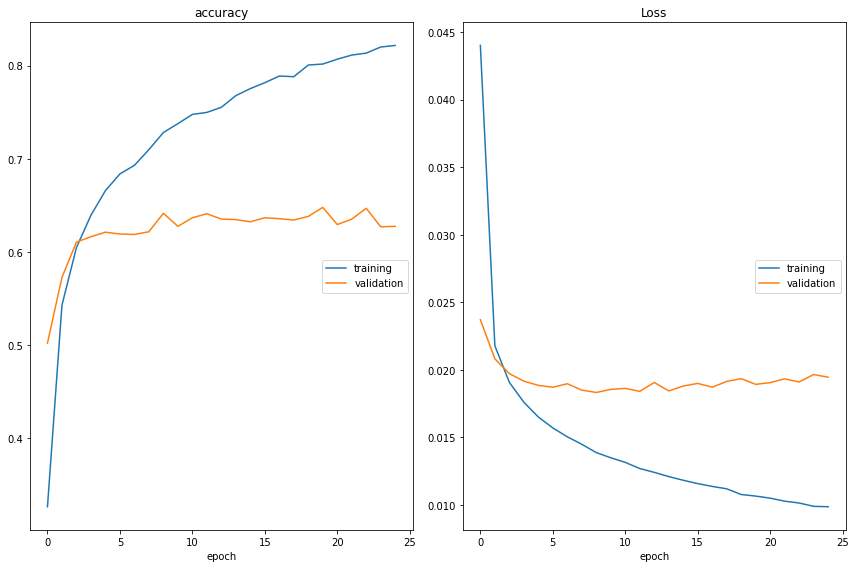

accuracy
	training         	 (min:    0.326, max:    0.822, cur:    0.822)
	validation       	 (min:    0.502, max:    0.648, cur:    0.627)
Loss
	training         	 (min:    0.010, max:    0.044, cur:    0.010)
	validation       	 (min:    0.018, max:    0.024, cur:    0.019)

Epoch 00025: val_accuracy did not improve from 0.64777


In [8]:
# Training
model.fit_generator(generator=training_generator,
                    #class_weight=class_weights,
                    steps_per_epoch=training_generator.n // training_generator.batch_size,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n // validation_generator.batch_size,
                    callbacks=[PlotLossesKeras(), 
                               ModelCheckpoint(MODEL_PATH,
                                               monitor='val_accuracy',
                                               mode='max',
                                               save_best_only=True,
                                               verbose=1)],
                    epochs=EPOCHS)
model = load_model(MODEL_PATH)

In [9]:
# Testing
testing_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
testing_generator = testing_data_generator.flow_from_dataframe(dataframe=testing_df,
                                                               directory=DATASET_PATH,
                                                               x_col=IMAGE_PATH_KEY,
                                                               batch_size=1,
                                                               seed=RANDOM_SEED,
                                                               shuffle=False,
                                                               class_mode=None,
                                                               target_size=(IMAGE_SIZE, IMAGE_SIZE))
predictions = model.predict_generator(testing_generator,
                                      steps=testing_generator.n,
                                      verbose=1)

Found 500 validated image filenames.


c:\users\eric_\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


500/500 [==============================] - 8s 14ms/step


In [10]:
for prediction in predictions:
    print(prediction)

[3.7319900e-05 2.8774738e-03 2.2992492e-04 2.0554533e-07 5.9631257e-06
 5.5978000e-03 5.1005512e-01 2.8491567e-07 5.1076450e-09 1.4731744e-06
 6.5868635e-06 4.8662126e-03 8.9491725e-05 6.8640709e-04 1.3688207e-04
 1.2701610e-05 7.4309111e-04 1.2719333e-03 1.2879491e-02 2.7478944e-07
 1.0697419e-05 7.5324053e-08 6.7514350e-07 6.7119785e-05 1.8599453e-06
 1.4402235e-06 5.4225355e-05 1.2566305e-05 2.1538138e-04 7.5301528e-04
 3.2430887e-04 2.5818512e-05 2.5330510e-07 2.1844973e-05 3.8464590e-05
 3.9328933e-02 2.7745088e-07 1.6218578e-07 3.3029914e-03 1.4488995e-03
 5.7446957e-04 2.0122528e-04 5.5382550e-03 8.7530893e-08 4.7663299e-08
 1.1337498e-05 4.9091199e-08 6.0317572e-05 3.0481667e-07 3.6427007e-06
 9.8462112e-07 1.7404301e-06 1.2561415e-07 1.4954398e-07 1.4561676e-05
 3.9821863e-04 2.8515801e-06 1.6293006e-07 5.4413084e-07 5.0961095e-05
 8.9293593e-07 2.7855259e-08 8.5981264e-06 3.4340625e-05 4.8062305e-09
 1.1582646e-06 7.0153415e-05 3.7636373e-06 5.4613969e-07 3.0719934e-06
 5.875

 2.48245868e-09]
[1.65646076e-02 7.13655595e-07 7.57845191e-05 4.30708405e-06
 7.00071496e-06 1.64365559e-07 9.15944576e-04 8.71803252e-08
 1.63327921e-10 4.25815142e-06 8.58048210e-08 2.44346866e-05
 9.79098877e-06 6.52537330e-11 4.45860624e-03 6.45480395e-05
 8.10984238e-06 4.15294999e-05 3.69859026e-06 3.30617979e-07
 2.47499599e-07 3.06956707e-07 1.15195803e-06 6.46978617e-04
 2.27015913e-02 2.60654498e-10 1.01619959e-03 2.18987465e-04
 2.90657499e-06 4.33463902e-06 6.46449407e-05 5.60183480e-07
 1.16044666e-05 7.74822340e-09 1.59944284e-05 2.14522083e-06
 4.05195566e-09 4.36292169e-07 9.03088537e-09 3.18547535e-08
 1.15524685e-07 6.13150187e-05 2.76611530e-07 2.24335195e-09
 4.99218702e-04 4.58818050e-07 4.94658947e-04 5.78805093e-09
 3.08164250e-09 2.78998186e-06 1.50563801e-06 4.32632730e-09
 7.62132913e-07 7.80107512e-05 3.65595525e-07 4.03636098e-02
 5.79342740e-10 2.56344777e-07 1.47200308e-06 1.54209076e-07
 1.31819320e-08 6.19428242e-09 2.97392347e-07 5.07604014e-10
 5.1615

 8.4480643e-04]
[9.63761693e-09 2.66164541e-04 1.50939799e-11 6.01348860e-10
 1.24234091e-07 3.90933906e-07 8.13531145e-08 4.02327532e-06
 5.71577286e-10 6.03457011e-07 1.92552452e-05 5.61951674e-06
 9.81500079e-07 1.80800477e-08 2.75496473e-06 3.41115697e-06
 3.61472701e-07 5.17624983e-08 1.74072881e-08 7.23679705e-07
 2.62945890e-04 1.18028898e-09 6.63212404e-07 7.13735562e-06
 1.21803705e-08 4.59134579e-04 6.75651027e-05 2.65362630e-08
 9.19523472e-07 1.35320352e-06 3.61327238e-07 1.50067638e-08
 9.76282239e-01 5.13255596e-04 9.29214217e-09 4.28133535e-05
 1.07693672e-03 6.65611299e-09 2.58602390e-10 2.15534419e-05
 2.06070645e-08 2.85231323e-07 1.78746244e-08 4.34457615e-06
 1.09877298e-08 1.57797933e-02 5.51885593e-10 1.79569781e-06
 1.72604887e-05 5.59127557e-06 6.44743443e-04 8.45281234e-10
 5.77936135e-08 1.54358624e-08 1.15878947e-06 1.17291621e-10
 1.26653910e-03 5.94702398e-10 1.71911929e-09 1.52832824e-09
 1.11432882e-06 4.98090740e-05 1.78277493e-04 7.34605408e-08
 1.26397

 1.19410970e-05]
[1.67024646e-05 5.89582305e-06 1.97676755e-08 3.48238757e-07
 1.66679097e-08 1.31636858e-04 7.37873488e-05 3.72712000e-11
 1.69604590e-07 4.06163778e-08 4.61262465e-03 2.01213360e-03
 6.38694110e-06 4.36054215e-09 9.69302237e-01 2.78413296e-04
 2.80955434e-03 4.77025242e-05 9.71776899e-06 9.03606415e-04
 5.72819363e-06 3.95526627e-07 5.34491029e-09 5.95445613e-07
 7.02253715e-07 1.83910131e-04 4.70319390e-03 2.31027603e-04
 1.65977752e-07 1.91056824e-06 1.10793178e-06 9.17506568e-08
 2.87294388e-04 3.71843576e-04 2.37912744e-07 1.66368484e-03
 2.77916818e-08 7.12100388e-08 1.32925251e-07 1.52885914e-04
 2.76181363e-05 3.12497616e-02 2.62760022e-06 3.15386057e-03
 1.61967755e-08 9.00095620e-05 6.69940255e-06 1.69998498e-06
 1.49693221e-07 2.01196781e-05 7.89165497e-04 5.61923486e-09
 3.33191821e-08 1.61221561e-08 1.49012897e-06 6.99021712e-07
 4.11170845e-07 3.74981340e-07 1.12435904e-04 1.47590924e-12
 4.35020011e-05 5.43295528e-07 6.20103890e-07 5.69001024e-08
 3.0239

 2.6482467e-06]
[6.20402643e-05 1.24938606e-06 4.33350863e-07 7.87987953e-10
 1.46241132e-06 1.40119552e-08 3.37859024e-06 1.48548968e-11
 9.48564827e-01 9.65587246e-12 1.75911623e-06 9.12824180e-06
 7.79741782e-08 8.18738144e-08 8.36380934e-07 1.11551280e-07
 2.41021917e-06 9.89967793e-06 3.83044529e-08 6.40839338e-03
 3.62884884e-06 9.53315898e-11 9.59512818e-07 7.23898097e-08
 2.31310370e-12 2.38995335e-06 3.65682195e-06 2.76838222e-07
 1.63232088e-02 3.65701169e-07 4.25050166e-05 1.92380649e-05
 1.53511763e-04 1.52989159e-07 6.03141430e-08 3.96085125e-06
 1.38805703e-07 3.31379379e-05 4.12024992e-09 6.55320093e-07
 2.20406937e-09 7.45691477e-06 1.36556741e-06 1.45649472e-06
 4.74184752e-04 1.95883749e-05 4.09048516e-06 1.92390280e-06
 2.57820830e-06 1.87591104e-05 9.64223204e-07 3.21810106e-10
 2.50703058e-09 7.30791205e-09 8.09563439e-09 2.46958010e-09
 3.42841755e-09 2.33193933e-12 4.86590013e-09 1.11987974e-09
 2.19842354e-06 4.81723674e-08 1.07339591e-04 3.06353343e-09
 2.07211

 1.6605250e-05]
[5.5603749e-08 6.2319768e-06 5.8059935e-10 2.2367862e-08 6.2091127e-10
 5.0708390e-08 5.0237708e-07 7.1735342e-14 4.0983082e-07 4.0088564e-11
 8.8465313e-05 6.3469112e-03 1.2225450e-05 5.3366620e-08 2.6831136e-05
 1.1413748e-04 9.6242726e-03 3.6847592e-07 5.2477679e-07 2.3970008e-04
 9.3435748e-09 3.8732774e-06 1.2628137e-09 6.6273564e-09 2.2684198e-05
 4.2097207e-07 4.1350722e-04 3.1920500e-08 3.9968154e-06 6.3471839e-07
 1.5735972e-06 2.0096269e-10 1.9058585e-04 3.4970009e-05 2.5716038e-09
 4.5270011e-05 3.4393178e-08 2.0296619e-10 9.4631081e-10 3.0675530e-04
 4.9309543e-09 3.6760271e-03 4.6922577e-11 8.8452025e-06 1.6375357e-06
 8.7502599e-04 7.6229787e-09 3.9864512e-09 9.8059016e-10 6.6409267e-11
 2.5044788e-05 2.2393196e-10 1.1180567e-06 7.6186291e-10 2.7025484e-09
 2.5110877e-10 3.3067769e-12 1.0148649e-07 1.7849661e-07 1.2789789e-10
 3.4588978e-05 5.8489313e-06 3.4079949e-05 2.8734148e-09 2.0466629e-07
 2.5296279e-07 4.2399306e-09 1.6969867e-08 2.3503109e-11 4.41

 1.37513680e-07]
[2.02610835e-07 3.75539064e-04 2.61685818e-05 7.48664141e-04
 1.13427472e-08 2.01949477e-03 1.27196312e-04 1.83675274e-05
 2.45630112e-08 1.00387965e-07 9.31105018e-03 1.30546093e-03
 4.95940447e-04 6.22073931e-05 1.81922317e-03 8.10401252e-06
 1.06434614e-04 4.07005791e-05 3.31907086e-06 1.64199173e-02
 1.41732693e-02 4.82446239e-07 2.39296605e-06 6.75375929e-07
 1.20949924e-04 5.63274000e-07 1.65611506e-04 1.50737166e-02
 1.60210839e-05 5.52377999e-02 1.51599602e-06 3.03949764e-06
 3.55145335e-03 8.27846306e-05 4.42415476e-04 2.49356031e-04
 3.29982953e-07 9.98229516e-05 6.98328018e-04 2.45093688e-05
 1.76676349e-05 1.59519911e-03 1.05562533e-04 2.48402357e-03
 1.13853348e-05 1.69654431e-05 1.64740300e-07 3.71054739e-07
 3.92484753e-06 9.50481044e-05 3.72453809e-01 7.94549351e-08
 2.78184640e-08 7.97048870e-07 4.88050318e-05 2.31683254e-04
 1.78694725e-04 3.58272700e-07 6.97212158e-07 1.37225529e-08
 1.19154509e-04 2.21083246e-06 1.02690770e-04 3.52938787e-06
 8.0846

 7.9162228e-06]
[3.59238364e-08 1.58926696e-06 2.50938342e-06 1.34678376e-05
 9.59604979e-04 1.85375632e-06 1.21549368e-02 5.65379858e-04
 4.09172790e-05 1.52767543e-09 6.95580093e-06 3.55511904e-04
 2.51799822e-04 1.30653381e-03 3.09318304e-04 1.84565783e-04
 1.80433508e-05 1.11976266e-03 5.88541013e-07 6.23941422e-04
 5.76138496e-04 1.72787757e-08 5.60134649e-04 8.45909119e-04
 9.72629355e-09 2.55581335e-06 3.41426016e-07 1.90287828e-04
 2.03502423e-05 8.16943896e-07 4.79727983e-04 2.35736370e-04
 6.11263715e-07 9.69008511e-07 1.24719739e-03 5.26225904e-06
 4.51730157e-05 1.24943256e-03 1.49309635e-03 4.05499850e-05
 4.24653292e-04 7.51112602e-05 4.19527292e-04 2.18865534e-05
 1.65116787e-03 6.78172569e-07 1.05816270e-07 4.01398529e-06
 1.96549554e-05 1.69789419e-05 3.53908539e-03 1.14031877e-07
 3.09809689e-09 4.17928732e-07 2.96215148e-07 1.77656045e-06
 8.40184725e-07 8.67901463e-07 2.19212598e-06 3.84846330e-03
 3.73452902e-04 1.62285346e-06 1.45137310e-04 1.23590231e-04
 3.14397

 1.07220934e-11]
[1.61864534e-07 1.44839287e-04 1.01792548e-08 5.28556825e-07
 7.34537840e-04 2.82770287e-08 3.57380685e-07 2.94980691e-05
 4.03195620e-04 9.47776755e-08 5.31971455e-04 1.06621948e-04
 7.81991257e-05 1.81204081e-03 1.11014178e-05 1.62935589e-06
 2.51986808e-06 1.57250952e-06 1.09183884e-05 3.82125378e-04
 4.93457913e-03 4.17833093e-07 8.41316876e-07 1.72908767e-06
 2.79226029e-08 1.19622864e-05 4.85013459e-07 2.17794991e-06
 5.60468607e-06 1.35988284e-06 6.43342733e-04 1.69214606e-03
 3.38164136e-05 2.24918127e-04 1.55895948e-04 2.02000141e-04
 1.77742481e-06 8.83172906e-05 1.03528466e-04 1.47823380e-06
 9.26210123e-06 3.10861850e-07 2.89636591e-05 1.32763525e-08
 1.22862926e-04 2.60349952e-06 1.02932933e-08 1.47819519e-04
 3.69147357e-09 1.47110066e-08 1.83547090e-05 5.31439946e-05
 2.77398776e-05 5.91960614e-09 1.22780506e-07 1.11230250e-07
 1.63614871e-07 3.96951805e-08 2.74097056e-06 2.83906274e-06
 1.99288130e-04 4.61268610e-06 4.93943691e-03 2.02667415e-02
 1.6309

 4.28828386e-08]
[6.40682776e-12 5.00283193e-08 1.83341172e-07 7.75244313e-11
 7.99506605e-01 1.17061312e-08 1.08023714e-08 7.44391900e-06
 4.87417196e-07 1.15770783e-12 3.18522630e-08 7.24568145e-06
 2.39064263e-07 1.96350570e-07 1.72389616e-06 4.65928487e-08
 4.51444798e-10 6.46210196e-07 3.05139780e-09 1.07770379e-08
 1.33518506e-06 2.88275395e-08 5.12778759e-04 1.61691278e-05
 1.00882983e-11 2.14449969e-09 1.02438591e-08 2.17342858e-06
 6.92195856e-10 1.02790006e-10 5.28263809e-06 8.94754350e-01
 3.45490303e-10 1.34603255e-07 4.66436148e-04 2.11100470e-07
 9.02022457e-10 2.01081389e-06 8.50062989e-08 1.01267267e-06
 6.76723766e-06 3.51142774e-07 4.19037194e-10 4.98194229e-11
 3.17456227e-07 2.40551135e-10 8.17660961e-09 6.51928123e-10
 3.25171383e-11 1.28935973e-09 2.44232467e-07 4.04822416e-13
 6.75137203e-12 8.05735687e-12 1.68949725e-08 2.22344488e-06
 2.66405795e-08 8.21384702e-08 1.94594719e-07 2.08335587e-06
 3.54769303e-09 1.46683554e-09 1.02302215e-06 2.51148890e-07
 9.7636

 1.32349072e-07]
[1.22825140e-05 6.62152052e-01 2.83305546e-10 4.91570429e-09
 6.99286829e-06 4.71722524e-06 8.52892626e-05 1.65863268e-10
 5.57297264e-10 3.14437415e-07 7.90540071e-05 1.06208954e-05
 2.30450482e-07 2.10314793e-05 8.71655686e-07 1.60837015e-08
 1.02341346e-06 3.40516854e-05 1.35194591e-06 5.62303921e-06
 9.03448665e-07 1.51360933e-08 1.02443536e-07 1.29652008e-07
 2.93076038e-04 7.88270256e-07 1.14383408e-06 1.02478034e-05
 2.30773551e-07 1.89354625e-06 5.46071460e-05 1.54256821e-04
 6.89814042e-05 6.66280698e-07 7.19452828e-06 9.76681709e-04
 2.52743831e-07 8.36448748e-07 7.34949135e-05 5.03450632e-04
 8.39058867e-09 1.35416398e-08 1.47988047e-07 2.31869173e-08
 8.26269453e-09 7.71399573e-06 1.26597314e-07 1.04695836e-07
 1.36595156e-06 8.91480965e-07 7.74485943e-06 3.26485065e-06
 4.62295553e-08 7.31601872e-08 1.23975369e-07 4.44643629e-05
 3.46699180e-09 7.22940911e-07 8.45067407e-05 8.91178686e-10
 4.28408384e-04 4.45231674e-09 2.21725855e-07 2.10234680e-06
 1.7109